# Ultimate Challenge - Retention Modeling

### Dependencies & data

In [1]:
# Dependencies
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.graph_objects as go
# import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Settings
# pd.options.plotting.backend = 'plotly'
sns.set()
%matplotlib inline

In [2]:
# User data
user_df = pd.read_json('ultimate_data_challenge.json')
user_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### Date columns

In [3]:
# Convert date columns to datetime
user_df['signup_date'] = pd.to_datetime(user_df['signup_date'])
user_df['last_trip_date'] = pd.to_datetime(user_df['last_trip_date'])
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

Signup date range: 2014-01-01 - 2014-01-31
Last-trip date range: 2014-01-01 - 2014-07-01


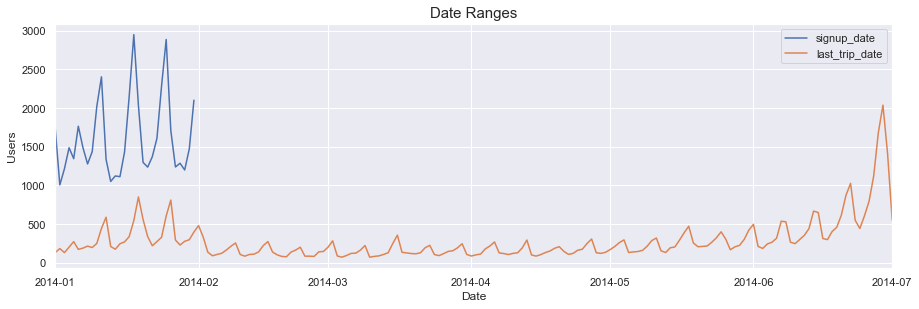

In [4]:
# Date ranges
user_df['signup_date'].value_counts().plot(figsize=(15, 5), legend=True,
                                           xlim=(user_df['signup_date'].min(), user_df['last_trip_date'].max()))
user_df['last_trip_date'].value_counts().plot(legend=True)
plt.title('Date Ranges', fontsize=15)
plt.xticks(rotation=0, ha='center')
plt.xlabel('Date')
plt.ylabel('Users')

print(f"Signup date range: {user_df['signup_date'].min().date()} - {user_df['signup_date'].max().date()}")
print(f"Last-trip date range: {user_df['last_trip_date'].min().date()} - {user_df['last_trip_date'].max().date()}")

##### The dataset contains only users who signed up in January but their data carries on for 6 months.

In [5]:
# Create binary indicators for date columns
user_df['first_month_user'] = user_df['trips_in_first_30_days'].apply(lambda t: min(t, 1))
user_df['retained_user'] = (user_df['last_trip_date'] >= dt.datetime(2014, 6, 1)).astype(int)

# Calculate days as user
user_df['days_as_user'] = (user_df['last_trip_date'] - user_df['signup_date']).dt.days # regression target label
user_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,first_month_user,retained_user,days_as_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,1,143
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,0,96
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1,0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,1,170
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1,0,47


##### The target variable `retained_user` indicates whether a user is currently a retained user (i.e., the user last used the service in the month of June). This doesn't account for the user's signup date in January so it wouldn't exactly be an accurate indicator of whether or not the user is active in their 6th month. For example, user A signed up on January 1st and user B signed up on January 31st. Both users last used the service on June 1st, which means they're both considered retained users, but user B has only been a member for 4 months (not 5). A better way of determining whether a user was active in their 6th month of use is to base it on `days_as_user`, which does account for their signup date. 

In [6]:
# Add a new classification target label based on days as user
user_df['retained_user_alt'] = (user_df['days_as_user'] > 150).astype(int)
user_df[user_df['retained_user'] != user_df['retained_user_alt']]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,first_month_user,retained_user,days_as_user,retained_user_alt
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,1,143,0
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0,1,1,148,0
13,King's Landing,0,2014-01-29,4.0,1.38,2014-06-08,iPhone,50.0,False,50.0,3.04,5.0,0,1,130,0
18,King's Landing,6,2014-01-28,4.6,1.21,2014-06-24,iPhone,30.8,True,80.8,6.83,4.8,1,1,147,0
23,King's Landing,0,2014-01-21,5.0,1.00,2014-06-13,Android,0.0,True,100.0,7.74,5.0,0,1,143,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49952,Astapor,3,2014-01-25,5.0,1.03,2014-06-24,iPhone,12.5,False,100.0,3.61,4.8,1,1,150,0
49962,Winterfell,2,2014-01-25,NaN,1.00,2014-06-12,iPhone,0.0,False,100.0,8.13,5.0,1,1,138,0
49966,King's Landing,4,2014-01-31,3.8,1.00,2014-06-21,iPhone,0.0,True,60.0,4.86,4.9,1,1,141,0
49988,King's Landing,1,2014-01-20,4.5,1.00,2014-06-14,iPhone,0.0,False,50.0,2.53,5.0,1,1,145,0


### Train/test split

In [7]:
def combinexy(X, y):
    return X.merge(y, left_index=True, right_index=True)

In [8]:
# Split features and labels
X = user_df.drop(['retained_user', 'retained_user_alt', 'days_as_user'], axis=1)
y = user_df['retained_user']
y_alt = user_df['retained_user_alt']
y_reg = user_df['days_as_user']
X.shape, y.shape, y_alt.shape

((50000, 13), (50000,), (50000,))

In [9]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=20)
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (40000, 13) (40000,)
Test: (10000, 13) (10000,)


In [10]:
# Combine train set
train_df = combinexy(X_train, y_train)
train_df.shape

(40000, 14)

### Duplicated data

In [11]:
# Duplicated count
X_train.duplicated().sum()

3

In [12]:
# Duplicated records
X_train[X_train.duplicated(keep=False)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,first_month_user
116,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0,1
26709,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0,1
3134,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0,1
29601,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0,1
45416,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0,1
39601,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0,1


##### It is unclear whether these are actually duplicated users, so they will not be dropped.

### Missing data

In [13]:
# Missing count
missing_df = pd.DataFrame(X_train.isnull().sum(), columns=['num_missing'])
missing_df['pct_missing'] = np.round(X_train.isnull().mean() * 100, 2)
missing_df[missing_df['num_missing'] > 0]

,num_missing,pct_missing
avg_rating_of_driver,6490,16.23
phone,310,0.78
avg_rating_by_driver,165,0.41


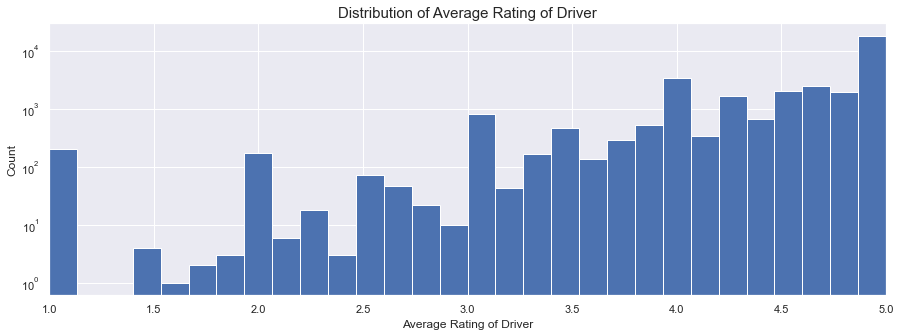

In [14]:
# Plot average rating of driver
X_train['avg_rating_of_driver'].plot(kind='hist', bins=30, figsize=(15, 5))
plt.title('Distribution of Average Rating of Driver', fontsize=15)
plt.xlabel('Average Rating of Driver')
plt.ylabel('Count')
plt.yscale('log')
plt.xlim(1, 5);

##### 6490 users did not rate their drivers. The assumption here is that these users experienced "average" rides (not good or bad enough to warrant taking the time to leave a review) so these missing driver ratings will be imputed with the mean driver rating. A similar assumption is made for `avg_rating_by_driver` so its values will be imputed with the mean. Missing `phone` values will be imputed with the most common phone among users.

In [15]:
# Impute rating columns with mean
X_train['avg_rating_of_driver'].fillna(round(X_train['avg_rating_of_driver'].mean(), 1), inplace=True)
X_train['avg_rating_by_driver'].fillna(round(X_train['avg_rating_by_driver'].mean(), 1), inplace=True)

# Impute phone column with mode
X_train['phone'].fillna(X_train['phone'].mode()[0], inplace=True)
X_train.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,first_month_user
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,2.272700,4.602358,1.075052,8.863862,61.015250,5.799195,4.776472,0.691200
std,3.791602,0.563884,0.224875,20.040742,37.071124,5.687513,0.449199,0.462004
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.800000,1.000000,0.000000,66.700000,3.890000,5.000000,1.000000
75%,3.000000,5.000000,1.050000,8.300000,100.000000,6.930000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,129.890000,5.000000,1.000000


##### The following 2 values in the dataframe above are exceedingly high and nowhere near their mean:
##### 1. `trips_in_first_30_days` max - to have taken 125 trips in the first 30 days means the user took an average of about 4 rides a day including on weekends
##### 2. `avg_dist` max - 129.89 miles is an excessive distance for an average distance
##### These outliers need to be inspected to see if they might be errors.

### Outliers

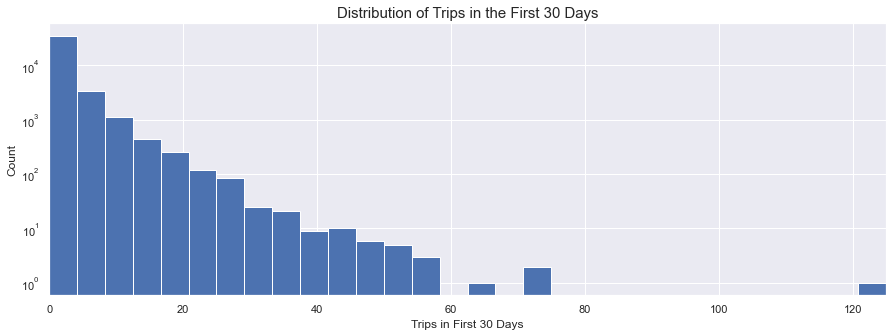

In [16]:
# Plot trips in first 30 days
X_train['trips_in_first_30_days'].plot(kind='hist', bins=30, figsize=(15, 5))
plt.title('Distribution of Trips in the First 30 Days', fontsize=15)
plt.xlabel('Trips in First 30 Days')
plt.ylabel('Count')
plt.yscale('log')
plt.xlim(0, X_train['trips_in_first_30_days'].max());

In [17]:
# Inspect outlier for trips in first 30 days
X_train[X_train['trips_in_first_30_days'] > 80]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,first_month_user
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8,1


##### It's hard to say whether or not this outlier is real data because the next highest `trips_in_first_30_days` value is under 80, but there's nothing about the user that really disputes this. Since this user has used Ultimate Black and has taken a ride on June 30th, it's likely that this is in fact a regular user. A `weekday_pct` of 72% means the user is not only taking rides on weekdays and an `avg_dist` of 2.02 miles could mean the user takes rides whenever he or she needs to go anywhere. To be clear, none of these things support the outlier is real, but rather they don't conflict with it.

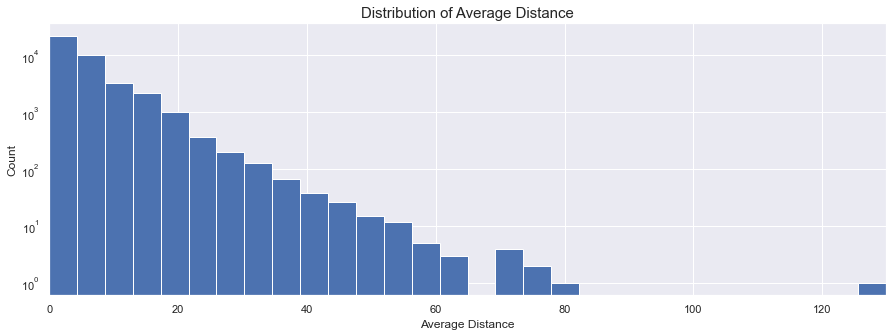

In [18]:
# Plot average distance
X_train['avg_dist'].plot(kind='hist', bins=30, figsize=(15, 5))
plt.title('Distribution of Average Distance', fontsize=15)
plt.xlabel('Average Distance')
plt.ylabel('Count')
plt.yscale('log')
plt.xlim(0, X_train['avg_dist'].max());

In [19]:
# Inspect outlier for average distance
X_train[X_train['avg_dist'] > 80]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,first_month_user
534,King's Landing,0,2014-01-04,4.6,1.0,2014-03-09,iPhone,0.0,False,0.0,129.89,5.0,0


##### Looking at the `trips_in_first_30_days`, `surge_pct`, `ultimate_black_user`, and `weekday_pct` values, it's plausible that this user has only taken 1 trip. The idea is that a long distance for a single ride is more likely than for an average of multiple rides. So there is not enough evidence to suggest this outlier is erroneous data.

### EDA

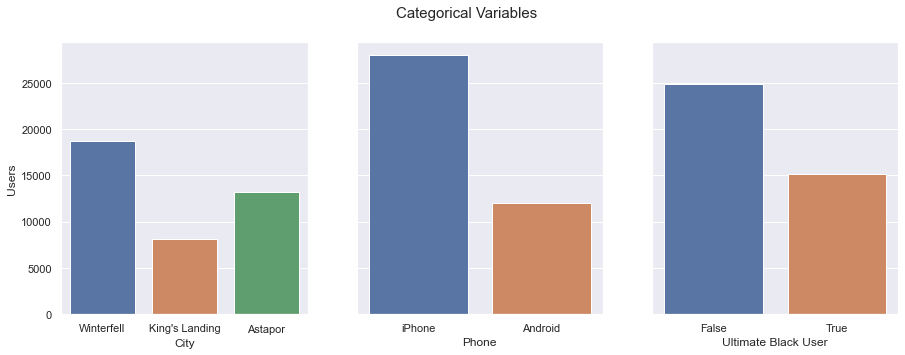

In [20]:
# # Convert `ultimate_black_user` to integer type
# X_train['ultimate_black_user'] = X_train['ultimate_black_user'].astype(int)

# Categorical variables
fig1, ax1 = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
sns.countplot(x=X_train['city'], ax=ax1[0])
sns.countplot(x=X_train['phone'], ax=ax1[1])
sns.countplot(x=X_train['ultimate_black_user'], ax=ax1[2])
fig1.suptitle('Categorical Variables', fontsize=15)
ax1[0].set_xlabel('City')
ax1[1].set_xlabel('Phone')
ax1[2].set_xlabel('Ultimate Black User')
ax1[0].set_ylabel('Users')
ax1[1].set_ylabel(None)
ax1[2].set_ylabel(None);

In [21]:
# Combine train set
train_df = combinexy(X_train, y_train)

# Count users in the first and last month
retained_users = pd.DataFrame(train_df[['first_month_user', 'retained_user']].sum(), columns=['num_users'])
retained_users['pct_users'] = train_df[['first_month_user', 'retained_user']].mean().round(4) * 100
retained_users

,num_users,pct_users
first_month_user,27648,69.12
retained_user,15043,37.61


In [22]:
# Retained users by first month usage
user_matrix = train_df[['first_month_user', 'retained_user']].copy()
user_matrix['lost_user'] = (user_matrix['retained_user'] == 0).astype(int)
user_matrix.groupby('first_month_user').sum().rename({0: False, 1: True})

,retained_user,lost_user
first_month_user,,
False,4466,7886
True,10577,17071


##### 15,043 of January signups were retained users, 10,577 of which used the service within their first 30 days.

In [23]:
# Users by city
train_df.groupby('city')[['first_month_user', 'retained_user']].sum()

,first_month_user,retained_user
city,,
Astapor,8945,3370
King's Landing,5257,5086
Winterfell,13446,6587


In [24]:
# Users by phone
train_df.groupby('phone')[['first_month_user', 'retained_user']].sum()

,first_month_user,retained_user
phone,,
Android,8324,2504
iPhone,19324,12539


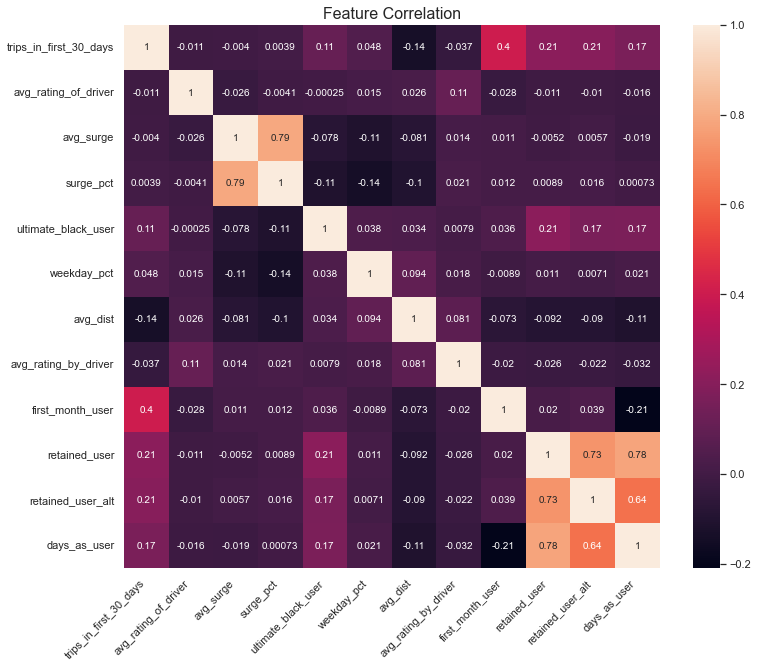

In [26]:
# Join other 2 labels into data
train_df = combinexy(combinexy(train_df, y_alt), y_reg)

# Feature correlation
corr = train_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True)
plt.title('Feature Correlation', fontsize=16)
plt.xticks(rotation=45, ha='right');

### Feature elimination

##### As the goal is to use 1 month of data to predict user retention 6 months after a user signs up (i.e., 5 months in the future), `signup_date` and `last_trip_date` would not be useful so those features will be dropped.

In [31]:
# Drop date-related features
X_train.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)
X_train.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,first_month_user,days_as_user
26245,Winterfell,2,4.3,1.02,iPhone,7.7,False,30.8,3.22,4.7,1,111
7179,Winterfell,5,3.5,1.04,iPhone,7.7,True,53.8,3.82,5.0,1,145
1951,Winterfell,2,3.5,1.00,iPhone,0.0,False,100.0,2.16,5.0,1,2
44384,King's Landing,2,5.0,1.00,iPhone,0.0,False,77.8,7.92,5.0,1,144
3836,Winterfell,3,5.0,1.00,iPhone,0.0,False,100.0,2.00,4.8,1,92


In [32]:
# Map categorical features to numerical values
city_dict = X_train.groupby('city')['days_as_user'].mean().round(2).to_dict()
phone_dict = X_train.groupby('phone')['days_as_user'].mean().round(2).to_dict()

# Encode the categorical variables in the training set
X_train['city'] = X_train['city'].map(city_dict)
X_train['phone'] = X_train['phone'].map(phone_dict)
X_train.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,first_month_user,days_as_user
26245,89.91,2,4.3,1.02,100.41,7.7,False,30.8,3.22,4.7,1,111
7179,89.91,5,3.5,1.04,100.41,7.7,True,53.8,3.82,5.0,1,145
1951,89.91,2,3.5,1.00,100.41,0.0,False,100.0,2.16,5.0,1,2
44384,116.79,2,5.0,1.00,100.41,0.0,False,77.8,7.92,5.0,1,144
3836,89.91,3,5.0,1.00,100.41,0.0,False,100.0,2.00,4.8,1,92


In [32]:
# Encode the categorical variables in the test set using the same mapping
X_test['city'] = X_test['city'].map(city_dict)
X_test['phone'] = X_test['phone'].map(phone_dict)
X_test.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,days_as_user
6596,82.63,0,4.5,1.00,75.66,0.0,1,100.0,5.04,4.7,58
25428,82.63,0,5.0,1.00,100.17,0.0,0,0.0,4.25,4.8,127
25780,89.82,4,4.9,1.12,75.66,14.3,0,50.0,3.69,4.8,174
48459,89.82,9,4.0,1.00,75.66,0.0,0,23.1,1.88,4.8,84
45942,116.47,1,4.0,1.00,75.66,0.0,1,100.0,3.85,5.0,5


##### The `days_as_user` variable was created to be the target in the case of regression, but kept among the feature variables in order to encoding the 2 categorical variables `city` and `phone` with the mean of each label. Now it can be separated from the feature variables.

In [33]:
y_train_reg = X_train['days_as_user']
X_train.drop('days_as_user', axis=1, inplace=True)
X_train.shape, y_train.shape

((39993, 10), (39993,))

In [34]:
# Check for constant features
X_train.var()

city                       151.899132
trips_in_first_30_days      14.600382
avg_rating_of_driver         0.321676
avg_surge                    0.048847
phone                      125.912195
surge_pct                  398.524581
ultimate_black_user          0.235447
weekday_pct               1372.443042
avg_dist                    32.894029
avg_rating_by_driver         0.199187
dtype: float64

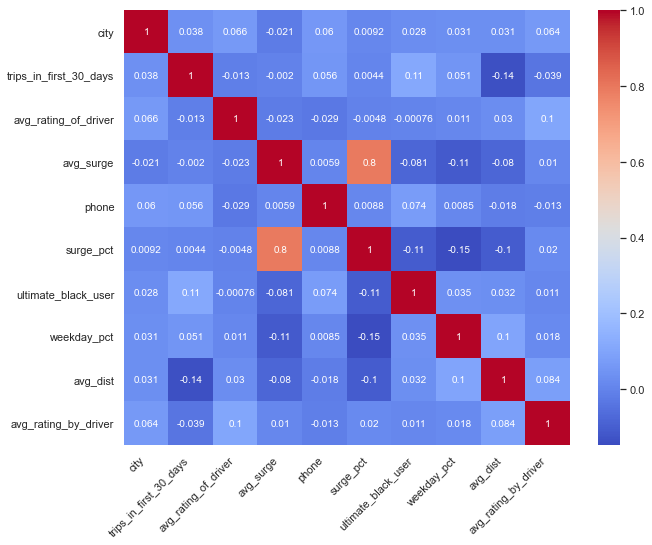

In [35]:
# Check for feature correlation
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.xticks(rotation=45, ha='right');

##### The 2 surge features are highly correlated so it would be redundant to have both. With a higher variance in its values, `surge_pct` might be able to provide more information so I am dropping `avg_surge`.

In [36]:
X_train.drop('avg_surge', axis=1, inplace=True)
X_train.shape

(39993, 9)

In [37]:
# Apply the same changes to the test set
y_test_reg = X_test['days_as_user']
X_test.drop(['avg_surge', 'days_as_user'], axis=1, inplace=True)
print('Test:', X_test.shape, y_test_reg.shape)

Test: (9999, 9) (9999,)


### Modeling

In [38]:
# Scale the features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train_scaled.head()

,city,trips_in_first_30_days,avg_rating_of_driver,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,1.916941,-0.337327,-1.057792,-1.531253,-0.444270,1.279120,-1.644569,0.520628,0.498437
1,-0.828791,0.186097,0.705386,-1.531253,-0.444270,1.279120,1.054775,-0.497634,0.498437
2,1.916941,0.447808,0.705386,0.653060,-0.444270,-0.781787,0.668769,4.497780,0.498437
3,-0.245404,0.709520,-1.057792,0.653060,1.559454,-0.781787,-0.024963,-0.527275,0.050306
4,-0.245404,-0.075615,0.705386,0.653060,-0.444270,-0.781787,0.155893,0.450884,-1.070021


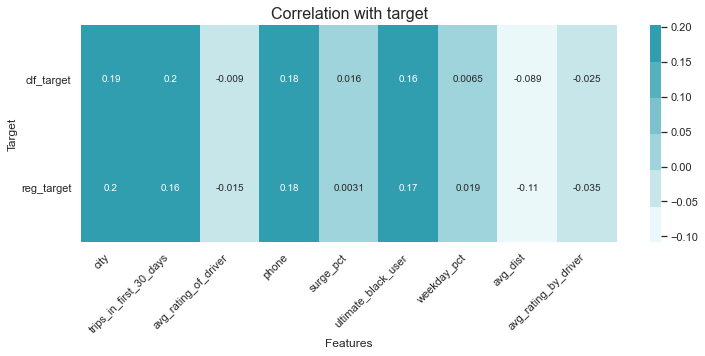

In [39]:
# Check feature correlation with the 2 targets
X_train_scaled['clf_target'] = y_train.reset_index().retained_user
X_train_scaled['reg_target'] = y_train_reg.reset_index().days_as_user

plt.figure(figsize=(12, 4))
sns.heatmap(X_train_scaled.corr().iloc[-2:, :-2], annot=True, cmap=sns.light_palette((210, 90, 60), input="husl"))
plt.title('Correlation with target', fontsize=16)
plt.ylabel('Target')
plt.xlabel('Features')
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')

X_train_scaled.drop(['clf_target', 'reg_target'], axis=1, inplace=True)

##### Features with the strongest linear relationship with target: `city`, `trips_in_first_30_days`, `phone`, and `ultimate_black_user`

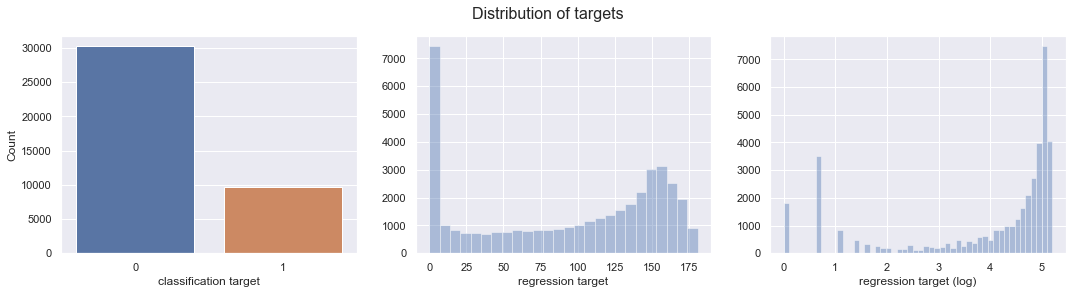

In [40]:
# Inspect targets
fig2, ax2 = plt.subplots(1, 3, figsize=(18, 4))
sns.countplot(y_train, ax=ax2[0])
sns.distplot(y_train_reg, kde=False, ax=ax2[1])
sns.distplot(np.log1p(y_train_reg), kde=False, ax=ax2[2])
fig2.suptitle('Distribution of targets', fontsize=16)
ax2[0].set_ylabel('Count')
ax2[0].set_xlabel('classification target')
ax2[1].set_xlabel('regression target')
ax2[2].set_xlabel('regression target (log)');

##### Classification target - slight class imbalance of 1:3, may not be a problem
##### Regression target - left-skewed with a peak at 0, log transformation unable to make it normally distributed

### Logistic Regression

In [41]:
# Logistic regression - 9 features
logreg = LogisticRegression(max_iter=1e4)
logreg.fit(X_train, y_train)

print('Train')
print('Score:', logreg.score(X_train, y_train))
print('ROC AUC:', roc_auc_score(y_train, logreg.predict(X_train)))
print('Confusion matrix:\n', confusion_matrix(y_train, logreg.predict(X_train), normalize='all'))

print('\nTest')
print('Score:', logreg.score(X_test, y_test))
print('ROC AUC:', roc_auc_score(y_test, logreg.predict(X_test)))
print('Confusion matrix:\n', confusion_matrix(y_test, logreg.predict(X_test), normalize='all'))

Train
Score: 0.7678843797664592
ROC AUC: 0.5701462382120047
Confusion matrix:
 [[0.72295152 0.03333083]
 [0.19878479 0.04493286]]

Test
Score: 0.7690769076907691
ROC AUC: 0.5707077316354442
Confusion matrix:
 [[0.72457246 0.03030303]
 [0.20062006 0.04450445]]


In [42]:
# Feature coefficients
logreg_coefs = pd.DataFrame(np.array([X_train_scaled.columns.values, logreg.coef_[0]]).T, columns=['feature', 'coefficient']).sort_values('coefficient', ascending=False)
logreg_coefs

,feature,coefficient
5,ultimate_black_user,0.681451
1,trips_in_first_30_days,0.0963701
3,phone,0.0386437
0,city,0.0332738
4,surge_pct,0.00246575
6,weekday_pct,-0.000128146
7,avg_dist,-0.0391387
2,avg_rating_of_driver,-0.0485882
8,avg_rating_by_driver,-0.144631


##### There are 6 features with a coefficient magnitude of less than 0.05, which means they are adding to the complexity of the model without providing much value. If the logistic regression model can achieve similar performance without these features, then there is really no need for them in using logistic regression.

In [43]:
# Logistic regression - 3 features
to_drop = ['weekday_pct', 'surge_pct', 'city', 'avg_dist', 'phone', 'avg_rating_of_driver']
logreg3 = LogisticRegression(max_iter=1e4)
logreg3.fit(X_train.drop(to_drop, axis=1), y_train)

print('Train')
print('Score:', logreg3.score(X_train.drop(to_drop, axis=1), y_train))
print('ROC AUC:', roc_auc_score(y_train, logreg3.predict(X_train.drop(to_drop, axis=1))))
print('Confusion matrix:\n', confusion_matrix(y_train, logreg3.predict(X_train.drop(to_drop, axis=1)), normalize='all'))

print('\nTest')
print('Score:', logreg3.score(X_test.drop(to_drop, axis=1), y_test))
print('ROC AUC:', roc_auc_score(y_test, logreg3.predict(X_test.drop(to_drop, axis=1))))
print('Confusion matrix:\n', confusion_matrix(y_test, logreg3.predict(X_test.drop(to_drop, axis=1)), normalize='all'))

Train
Score: 0.762608456479884
ROC AUC: 0.5301878805348416
Confusion matrix:
 [[0.74390518 0.01237717]
 [0.22501438 0.01870327]]

Test
Score: 0.761976197619762
ROC AUC: 0.5283972052547904
Confusion matrix:
 [[0.74477448 0.01010101]
 [0.22792279 0.01720172]]


##### Logistic regression summary:
##### - There was only a small drop in accuracy when training with 3 features vs. training with 9
##### - Most of the predictive power lies in the 3 features `ultimate_black_user`, `avg_rating_by_driver`, and `trips_in_first_30_days`
##### - Most of the misclassifications are false negatives (i.e. the user was active in his or her 6th month, but classified to be inactive)

### Decision Tree

In [44]:
# Decision tree - grid search
tree = DecisionTreeClassifier(random_state=0)
params = {'max_depth': range(4, 24, 4), 'min_samples_split': range(20, 440, 20)}
gs = GridSearchCV(tree, params, scoring='roc_auc', cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8013498615338296
{'max_depth': 12, 'min_samples_split': 320}


In [45]:
# Decision tree - 9 features
tree = DecisionTreeClassifier(max_depth=8, min_samples_split=220, random_state=0)
tree.fit(X_train, y_train)

print('Train')
print('Score:', tree.score(X_train, y_train))
print('ROC AUC:', roc_auc_score(y_train, tree.predict(X_train)))
print('Confusion matrix:\n', confusion_matrix(y_train, tree.predict(X_train), normalize='all'))

print('\nTest')
print('Score:', tree.score(X_test, y_test))
print('ROC AUC:', roc_auc_score(y_test, tree.predict(X_test)))
print('Confusion matrix:\n', confusion_matrix(y_test, tree.predict(X_test), normalize='all'))

Train
Score: 0.7965143900182532
ROC AUC: 0.6630927156524461
Confusion matrix:
 [[0.69834721 0.05793514]
 [0.14555047 0.09816718]]

Test
Score: 0.7967796779677968
ROC AUC: 0.6634450167641902
Confusion matrix:
 [[0.69826983 0.05660566]
 [0.14661466 0.09850985]]


In [46]:
# Feature Coefficients
tree_coefs = pd.DataFrame(np.array([X_train.columns.values, tree.feature_importances_]).T, columns=['feature', 'coefficient']).sort_values('coefficient', ascending=False)
tree_coefs

,feature,coefficient
8,avg_rating_by_driver,0.354745
4,surge_pct,0.266048
0,city,0.144092
3,phone,0.0786588
6,weekday_pct,0.0685235
5,ultimate_black_user,0.0426211
1,trips_in_first_30_days,0.0267832
7,avg_dist,0.015455
2,avg_rating_of_driver,0.00307394


In [47]:
# Decision tree - 3 features
to_drop = ['avg_rating_of_driver', 'avg_dist', 'trips_in_first_30_days', 'ultimate_black_user', 'phone', 'weekday_pct']
tree3 = DecisionTreeClassifier(max_depth=8, min_samples_split=220, random_state=0)
tree3.fit(X_train.drop(to_drop, axis=1), y_train)

print('Train')
print('Score:', tree3.score(X_train.drop(to_drop, axis=1), y_train))
print('ROC AUC:', roc_auc_score(y_train, tree3.predict(X_train.drop(to_drop, axis=1))))
print('Confusion matrix:\n', confusion_matrix(y_train, tree3.predict(X_train.drop(to_drop, axis=1)), normalize='all'))

print('\nTest')
print('Score:', tree3.score(X_test.drop(to_drop, axis=1), y_test))
print('ROC AUC:', roc_auc_score(y_test, tree3.predict(X_test.drop(to_drop, axis=1))))
print('Confusion matrix:\n', confusion_matrix(y_test, tree3.predict(X_test.drop(to_drop, axis=1)), normalize='all'))

Train
Score: 0.7895381691796064
ROC AUC: 0.63567356479576
Confusion matrix:
 [[0.70777386 0.04850849]
 [0.16195334 0.08176431]]

Test
Score: 0.7931793179317932
ROC AUC: 0.6408101978427415
Confusion matrix:
 [[0.70937094 0.04550455]
 [0.16131613 0.08380838]]


##### Decision tree summary:
##### - The 3 features with the highest importance coefficients (`avg_rating_by_driver`, `surge_pct`, `city`) were used to retrain the model and there was only a small drop in accuracy
##### - Both models agree that `avg_rating_by_driver` is an important feature
##### - Decision tree had better predictive performance than logistic regression

### Summary

##### - As of July 1, 2014, 18,804 (37.61%) of January signups are retained users because they were active in the month of June.
##### - I created the `days_as_user` feature using the time difference between the 2 original date columns. I considered using this feature as the target for regression, but there is a higher degree of uncertainty associated with continuous predictions and I felt that the large amount of 0 values might skew the predictions. 
##### - I chose logistic regression and decision tree for classification because these models are easy to interpret. Decision tree performed better overall, but both of them had a high false-negative rate. In other words, most of the misclassifications were active users being predicted as inactive users.
##### - Logistic regression model (accuracy of 0.7626 and ROC AUC score of 0.5302): used features `ultimate_black_user`, `avg_rating_by_driver`, and `trips_in_first_30_days`
##### - Decision tree model (accuracy of 0.7932 and ROC AUC score of 0.6408): used features `avg_rating_by_driver`, `surge_pct`, and `city`
##### - According to these classifiers, users who use the service in their first 30 days or use Ultimate Black are more likely to be active in their 6th month. Offering a percentage-off promotion for either or both of these is likely to increase user retention.
##### - Surge and rating by driver also seem to have some impact on the decision. Increasing surge frequency/rate and reaching out to drivers to resolve any low ratings may also increase user retention.